# Activation Foil Analysis: 1L BABY Run #8

This notebook processes the calibration data from HPGe detectors to energy calibrate the detectors and determine total detector efficiencies. Then, NaI measurements of activation foils irradiated during the run with a D-T neutron (14.1 MeV) generator are used to determine the average neutron rate during the run. 

## Obtaining the Data
First, the NaI detector measurement data is obtained from Zenodo and extracted

In [1]:
# parameters

## keep this if statement for ci and process workflows
if 'download_from_raw' not in globals() and 'download_from_raw' not in locals():
    download_from_raw = False

In [2]:
import numpy as np
from datetime import datetime
import json

In [3]:
from process_foil_data import get_data
check_source_measurements, background_meas, foil_measurements = get_data(download_from_raw=download_from_raw,
                                                                         detector_type='NaI')

detector_type:  ['HPGe', 'NaI']
Read in properties of Niobium Packet #1 foil
Read in properties of Niobium Packet #2 foil
Read in properties of Zr Packet #2 foil
Read in properties of Zr Packet #3 foil
Processing Background from h5 file...
Processing Co60 Count 1 from h5 file...
Processing Co60 Count 2 from h5 file...
Processing Cs137 Count 1 from h5 file...
Processing Cs137 Count 2 from h5 file...
Processing Mn54 Count 1 from h5 file...
Processing Mn54 Count 2 from h5 file...
Processing Na22 Count 1 from h5 file...
Processing Na22 Count 2 from h5 file...
Processing Niobium Packet #1 Count 1 from h5 file...
Processing Niobium Packet #1 Count 2 from h5 file...
Processing Niobium Packet #2 Count 1 from h5 file...
Processing Niobium Packet #2 Count 2 from h5 file...
Processing Zr Packet #2 Count 1 from h5 file...
Processing Zr Packet #2 Count 2 from h5 file...
Processing Zr Packet #3 Count 1 from h5 file...
Processing Zr Packet #3 Count 2 from h5 file...


## Energy Calibration

Using gamma check sources like Co-60 and Cs-137, the characteristic photon peaks from these sources are used to convert the digitizer channel bins into energy (keV) bins

  Measurement: Co60 Count 1, Nuclide: Co60
[<Axes: > <Axes: >]
[1553 1766]
Peaks found: [1453 1666]
peak_data: {'peak_heights': array([702., 572.]), 'prominences': array([702., 457.]), 'left_bases': array([  41, 1544]), 'right_bases': array([2047, 2047]), 'widths': array([106.12122845,  86.43010753]), 'width_heights': array([351. , 343.5]), 'left_ips': array([1394.671875  , 1611.16666667]), 'right_ips': array([1500.79310345, 1697.59677419])}
[1046 1186]
Peaks found: [ 946 1086]
peak_data: {'peak_heights': array([1089.,  917.]), 'prominences': array([1089.,  752.]), 'left_bases': array([  39, 1019]), 'right_bases': array([1881, 1881]), 'widths': array([65.97781385, 61.56855867]), 'width_heights': array([544.5, 541. ]), 'left_ips': array([ 908.98809524, 1049.390625  ]), 'right_ips': array([ 974.96590909, 1110.95918367])}
  Measurement: Co60 Count 2, Nuclide: Co60
[<Axes: > <Axes: >]
[1560 1764]
Peaks found: [1460 1664]
peak_data: {'peak_heights': array([802., 636.]), 'prominences': array

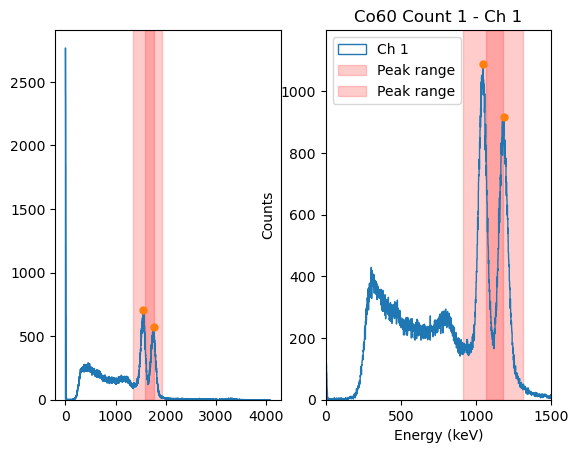

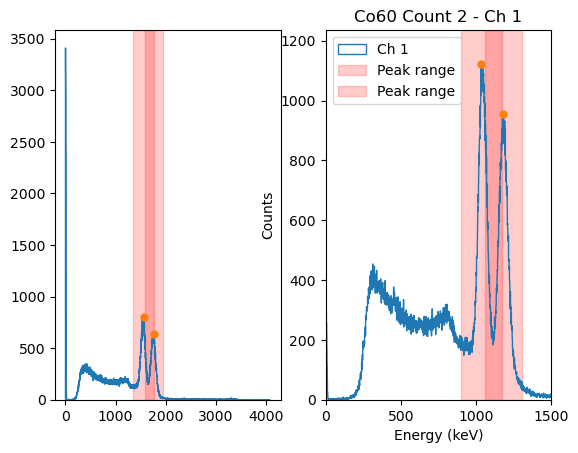

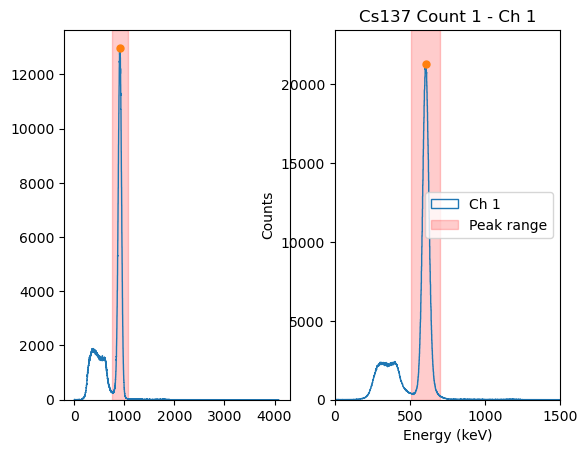

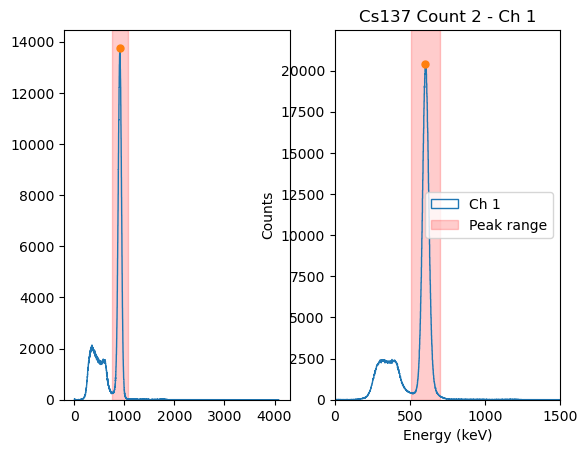

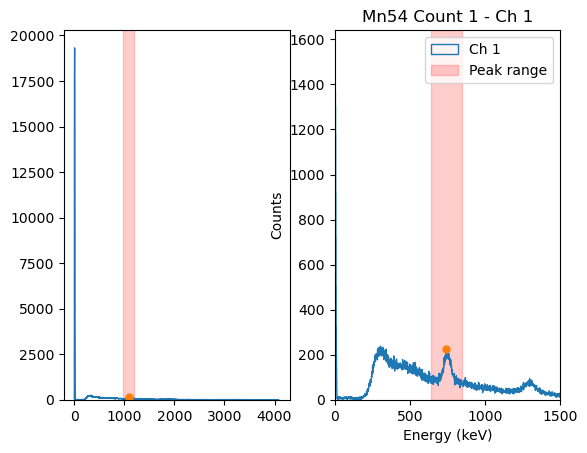

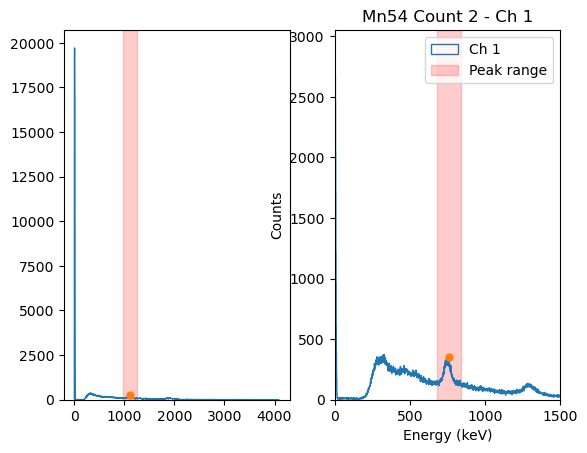

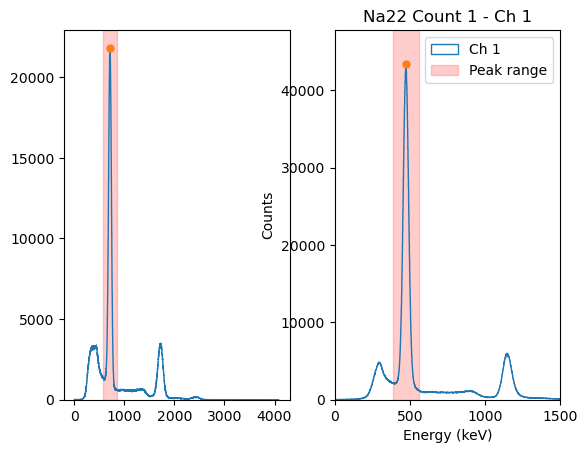

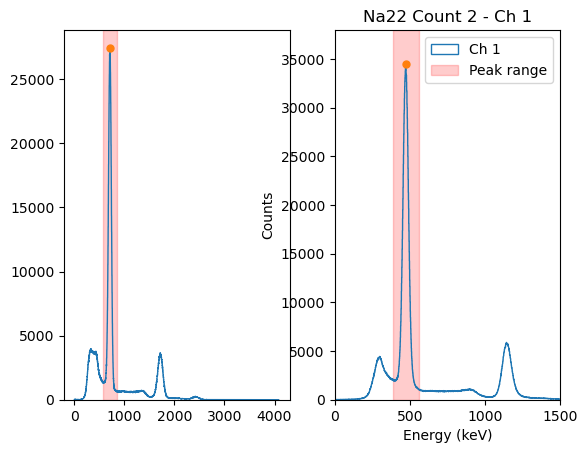

In [17]:
import matplotlib.pyplot as plt
from libra_toolbox.neutron_detection.activation_foils import compass
peak_parameters = {
    "Ba133": {
        "start_index": 150,
        "height": 0.1,
        "prominence": 0.1,
        "width": [2, 150],
        "distance": 10,
    },
    "Na22": {
        "start_index": 100,
        "height": 0.2,
        "prominence": 0.2,
        "width": [2, 150],
        "distance": 100,
    },
    "Co60": {
        "start_index": 100,
        "height": 0.5,
        "prominence": 0.5,
        "width": [2, 150],
        "distance": 10,
    },
    "Cs137": {
        "start_index": 10,
        "height": 0.5,
        "prominence": 0.5,
        "width": [2, 150],
        "distance": 100,
    },
    "Mn54": {
        "start_index": 400,
        "height": 0.4,
        "prominence": 0.4,
        "width": [2, 150],
        "distance": 100,
    }
}
for name, measurement in check_source_measurements.items():
    print(f"  Measurement: {name}, Nuclide: {measurement.check_source.nuclide.name}")
    fig, ax = plt.subplots(nrows=1, ncols=len(measurement.detectors))
    print(ax)
    if ax is not np.ndarray:
        ax = [ax]
    ax = np.array(ax).flatten()
    for d,detector in enumerate(measurement.detectors):
        print(detector)
        # print(detector._spectrum)
        hist, bin_edges = detector.get_energy_hist()
        ax[d].hist(
            bin_edges[:-1],
            bins=bin_edges,
            weights=hist,
            histtype="step",
            label=f"Ch {detector.channel_nb}",
        )
        peaks = measurement.get_peaks(hist)
        print(peaks)

        from scipy.signal import find_peaks
        import numpy as np

        # Use the peak parameters for the specific measurement
        params = peak_parameters.get(measurement.check_source.nuclide.name, peak_parameters["Ba133"])
        start_index = params["start_index"]
        height = params["height"] * np.max(hist[start_index:])
        prominence = params["prominence"] * np.max(hist[start_index:])
        width = params["width"]
        distance = params["distance"]
        peaks, peak_data = find_peaks(
            hist[start_index:],
            prominence=prominence,
            height=height,
            width=width,
            distance=distance,
        )
        print("Peaks found:", peaks)
        print("peak_data:", peak_data)
        ax[d].plot(bin_edges[start_index:][peaks], peak_data["peak_heights"], ".", ms=10)

        if not hasattr(measurement.check_source.nuclide, "peak_widths") or measurement.check_source.nuclide.peak_widths is None:
            measurement.check_source.nuclide.peak_widths = {}
        measurement.check_source.nuclide.peak_widths[detector.channel_nb] = 3 * peak_data["widths"]

        for i, p in enumerate(peaks):
            width = peak_data["widths"][i]
            ax[d].axvspan(
                bin_edges[start_index:][p] - width*2.0,
                bin_edges[start_index:][p] + width*2.0,
                color="red",
                alpha=0.2,
                label="Peak range",
            )
            # ax[d].axvspan(
            #     peak_data["right_bases"][i] + start_index,
            #     peak_data["left_bases"][i] + start_index,
            #     color="red",
            #     alpha=0.2,
            #     label="Peak range",
            # )

    ax[d].legend()
    # plt.yscale("log")
    ax[d].set_xlim(left=0, right=1500)
    ax[d].set_ylim(top=1.1 * np.max(hist))
    ax[d].set_title(f"{measurement.name} - Ch {detector.channel_nb}")
    ax[d].set_xlabel("Energy (keV)")
    ax[d].set_ylabel("Counts")
plt.show()

{'Co60 Count 1': <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x188fd6c30>, 'Co60 Count 2': <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x1897e98b0>, 'Cs137 Count 1': <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x1897e9970>, 'Cs137 Count 2': <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x1897e9a60>, 'Mn54 Count 1': <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x1897e9a90>, 'Mn54 Count 2': <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x1897e9ac0>, 'Na22 Count 1': <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x1897e9af0>, 'Na22 Count 2': <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x1897e9b20>}


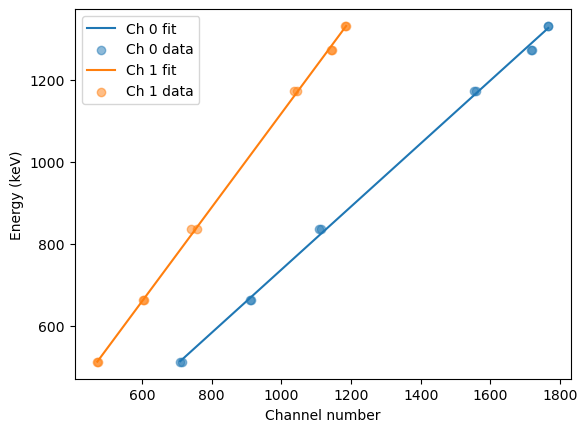

In [5]:
calibration_coeffs = {}
print(check_source_measurements)
for channel_nb in [0,1]:
    calibration_channels, calibration_energies = compass.get_calibration_data(
        check_source_measurements.values(),
        background_measurement=background_meas,
        channel_nb=channel_nb,
    )

    coeff = np.polyfit(calibration_channels, calibration_energies, 1)
    calibration_coeffs[channel_nb] = coeff

    xs = np.linspace(
        calibration_channels[0],
        calibration_channels[-1],
    )
    plt.plot(
        xs,
        np.polyval(coeff, xs),
        label=f"Ch {channel_nb} fit",
    )
    plt.scatter(
        calibration_channels,
        calibration_energies,
        label=f"Ch {channel_nb} data",
        alpha=0.5,
    )
plt.xlabel("Channel number")
plt.ylabel("Energy (keV)")
plt.legend()
plt.show()

## Detector Efficiency

Using these same check-sources, each with a known activity, an efficiency curve for each detector is calculated. 

Two types of efficiency curves are shown: 
1. Exponent of sum of logarithms (used in https://doi.org/10.2172/1524045): $ y = \exp(\sum_{i=0}^n a_n \log(E)^i) $

2. Polynomial fit (3rd order): $ y = \sum_{i=0}^n a_n E^i $

**Only the polynomal fit is currently implemented in libra-toolbox, so that is the curve that will be used to calculate the efficiency of the detectors at measuring the activity of the activation foil peaks.**

In [6]:
def eff_curve_func(E, *a):
    exponent_term = 0
    for i,a_n in enumerate(a):
        exponent_term += a_n * (np.log(E) ** i)
    return np.exp(exponent_term)

Co60 Count 1 <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x188fd6c30>
Uncalibrated measured energies: [np.int64(1560), np.int64(1764)]
Calibration coefficients: [  0.77133519 -34.8305728 ]
Calibrated measured energies: [1168.45232403 1325.80470285]
TOOLBOX: Guessed parameters:  [0, 0, np.float64(625.1683160032978), np.float64(1168.4523240298095), 55.0, np.float64(466.76356185503226), np.float64(1325.8047028456317), 55.0]
TOOLBOX: Peak energy: 1168.4523240298095  Gross area: 63140.12901613876  Cutoff area: 15839.45378610727  Net area: 47300.67523003149
TOOLBOX: Peak energy: 1325.8047028456317  Gross area: 51965.64842204502  Cutoff area: 8810.549652370762  Net area: 43155.09876967426
Co60 Count 2 <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x1897e98b0>
Uncalibrated measured energies: [np.int64(1560), np.int64(1764)]
Calibration coefficients: [  0.77133519 -34.8305728 ]
Calibrated measured energi

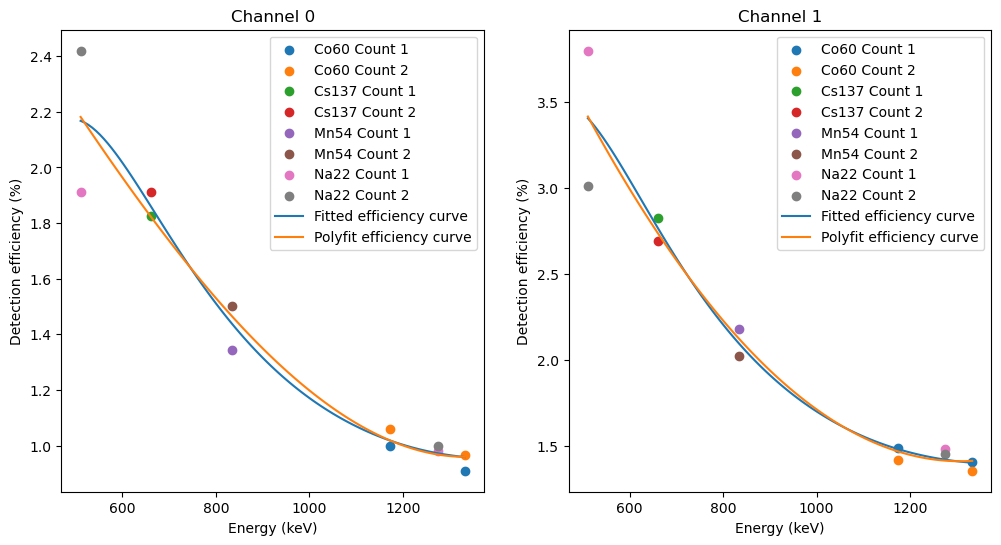

In [7]:
from scipy.optimize import curve_fit

channels = []
efficiency_coeffs = {}
measurement = list(check_source_measurements.values())[0]
search_width = 330

for detector in measurement.detectors:
    channels.append(detector.channel_nb)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
for i,ch in enumerate(channels):
    background_detector = background_meas.get_detector(ch)
    energies = []
    efficiencies = []
    for name, measurement in check_source_measurements.items():
        print(f"{name}", measurement)
        check_source_detector = measurement.get_detector(ch)
        hist, bin_edges = check_source_detector.get_energy_hist_background_substract(background_detector)
        calibrated_bin_edges = np.polyval(calibration_coeffs[ch], bin_edges)
        
        efficiency = measurement.compute_detection_efficiency(
            background_measurement=background_meas,
            calibration_coeffs=calibration_coeffs[ch],
            channel_nb=ch,
            search_width=search_width,
        )
        energies += measurement.check_source.nuclide.energy
        efficiencies += list(efficiency)
        ax[i].scatter(
            measurement.check_source.nuclide.energy,
            efficiency * 100,
            label=name,
        )

    # Sort energies and efficiencies for fitting
    sorted_indices = np.argsort(energies)
    energies = np.array(energies)[sorted_indices]
    efficiencies = np.array(efficiencies)[sorted_indices]
    print(f"Ch {ch} \n\t Energies: {energies}, \n\t Efficiencies: {efficiencies}")

    # Fit the efficiency curve
    popt, pcov = curve_fit(
        eff_curve_func,
        energies,
        efficiencies,
        p0=[-1, 1, 0, 0],
    )

    poly_coeff = np.polyfit(energies, efficiencies, 3)
    efficiency_coeffs[ch] = poly_coeff
    xs = np.linspace(
        energies[0],
        energies[-1],
        100,
    )
    ax[i].plot(
        xs,
        eff_curve_func(xs, *popt) * 100,
        label="Fitted efficiency curve",
    )

    ax[i].plot(
        xs,
        np.polyval(poly_coeff, xs) * 100,
        label="Polyfit efficiency curve",
    )
    ax[i].set_xlabel("Energy (keV)")
    ax[i].set_ylabel("Detection efficiency (%)")
    ax[i].set_title(f"Channel {ch}")
    ax[i].legend()
    # plt.ylim(bottom=0)
    print(popt)
plt.show()

## Calculating average neutron rate from activation foils

First, the irradiation schedule and the foil information is collected.

In [8]:
all_neutron_rates = []
all_neutron_rates_err = []

In [9]:
from process_foil_data import irradiations, time_generator_off

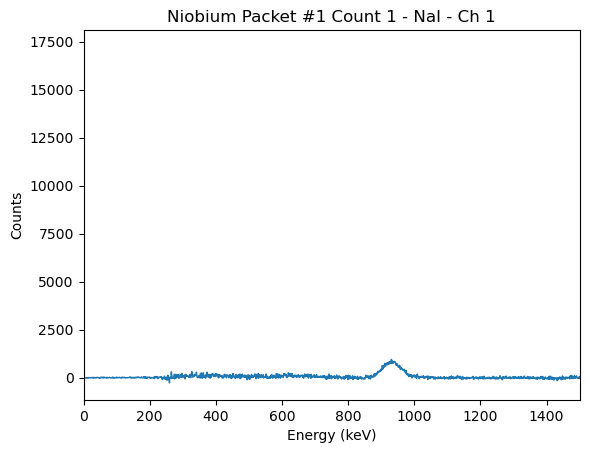

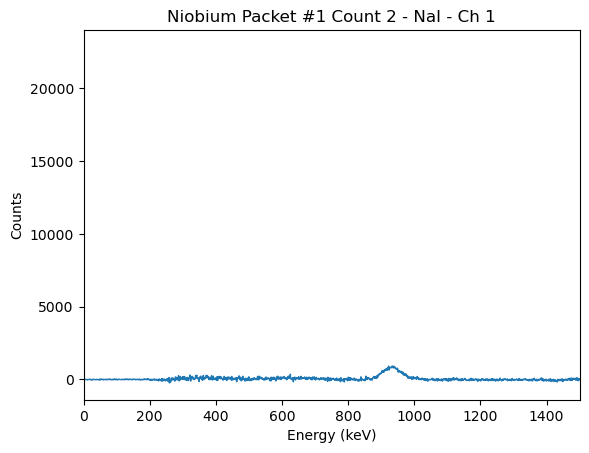

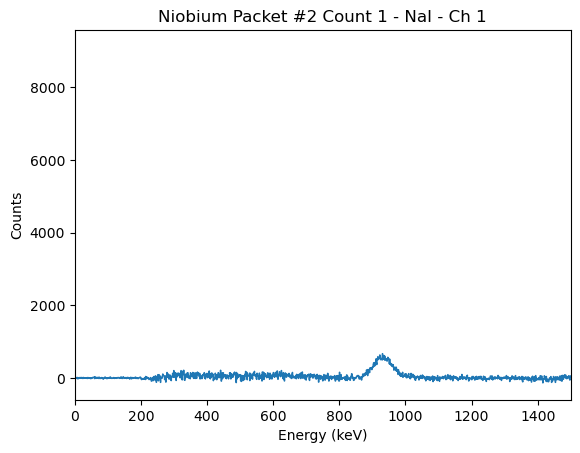

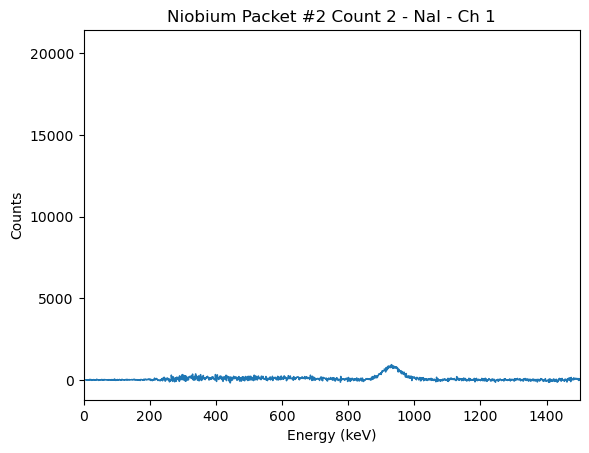

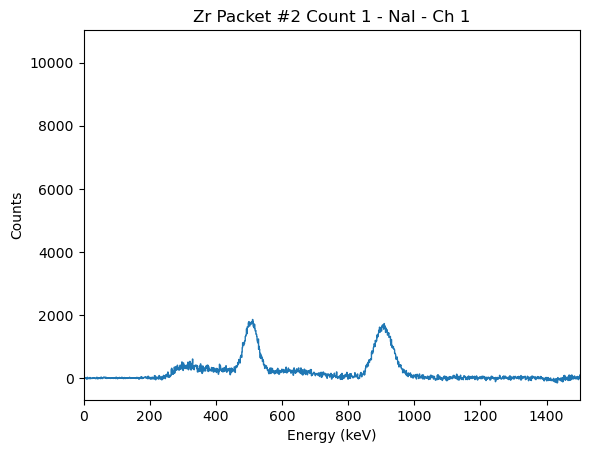

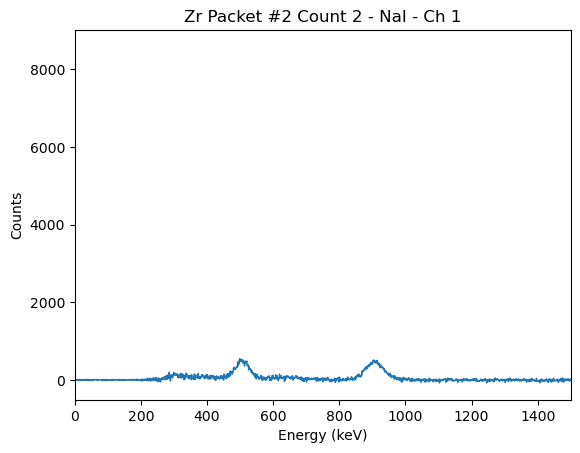

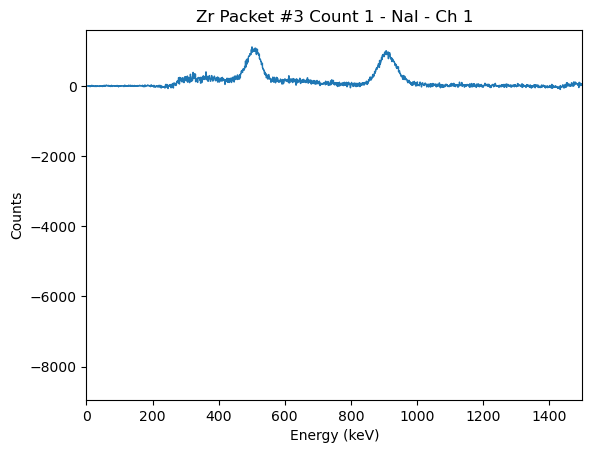

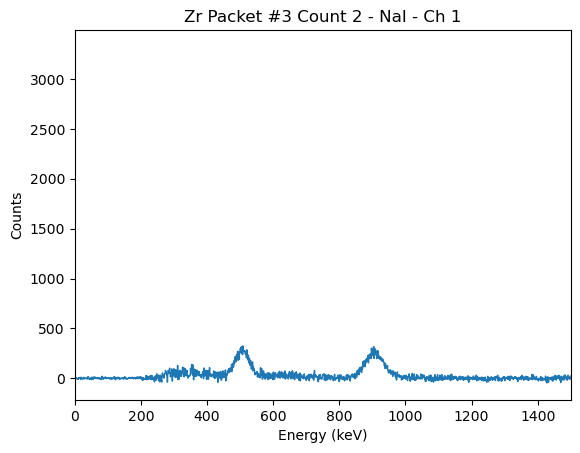

In [10]:
# plot background subtracted spectra for each foil measurement
for foil_name, measurement_dict in foil_measurements.items():
    for count_num, measurement in measurement_dict["measurements"].items():
        for detector in measurement.detectors:
            background_detector = background_meas.get_detector(detector.channel_nb)
            hist, bin_edges = detector.get_energy_hist_background_substract(background_detector)
            calibrated_bin_edges = np.polyval(calibration_coeffs[detector.channel_nb], bin_edges)
        plt.figure()
        plt.stairs(hist, calibrated_bin_edges)
        plt.xlim(left=0, right=1500)
        # plt.yscale("log")
        plt.title(f"{measurement.name} - NaI - Ch {detector.channel_nb}")
        plt.xlabel("Energy (keV)")
        plt.ylabel("Counts")
        plt.show()

### Niobium Packet #3 Results

The activity of Nb-92m is measured using its 934 keV gamma peak and used to determine the neutron rate during the irradiation. Nb-92m is formed from the Nb-93(n,2n) reaction, which has a threshold energy of 8.9 MeV. 

The gamma spectrum obtained from the various measurements of the Niobium Packet #3 after irradiation are used to calculate the neutron rate of the overall irradiation. 

In [11]:
from process_foil_data import calculate_neutron_rate_from_foil

foil_name = "Niobium Packet #1"

neutron_rates, neutron_rate_errs = calculate_neutron_rate_from_foil(foil_measurements,
                                                                    foil_name,
                                                                    background_meas,
                                                                    calibration_coeffs,
                                                                    efficiency_coeffs,
                                                                    search_width=300)

for count_name in neutron_rates.keys():
    print(count_name)
    for ch in np.sort(list(neutron_rates[count_name].keys())):
        neutron_rate = neutron_rates[count_name][ch]
        neutron_rate_err = neutron_rate_errs[count_name][ch]
        print(f"\t Ch {ch}: Neutron rate: {neutron_rate[0]:.3e} +/- {neutron_rate_err[0]:.3e} n/s")
        all_neutron_rates.append(neutron_rate[0])
        all_neutron_rates_err.append(neutron_rate_err[0])


TOOLBOX: Guessed parameters:  [0, 0, np.float64(423.0188579822192), 934.44, 100.0]
TOOLBOX: Peak energy: 934.44  Gross area: 39083.83639953479  Cutoff area: 849.6449119891267  Net area: 38234.191487545664
TOOLBOX: Guessed parameters:  [0, 0, np.float64(751.7534785087078), 934.44, 100.0]
TOOLBOX: Peak energy: 934.44  Gross area: 57887.13156446936  Cutoff area: 2532.058571899058  Net area: 55355.072992570305
TOOLBOX: Guessed parameters:  [0, 0, np.float64(525.4833598480724), 934.44, 100.0]
TOOLBOX: Peak energy: 934.44  Gross area: 40918.139079585206  Cutoff area: 2021.3154253100333  Net area: 38896.82365427517
TOOLBOX: Guessed parameters:  [0, 0, np.float64(816.5921927274874), 934.44, 100.0]
TOOLBOX: Peak energy: 934.44  Gross area: 59351.85744027253  Cutoff area: 2361.0236862634324  Net area: 56990.833754009094
Count 1
	 Ch 0: Neutron rate: 2.856e+08 +/- 1.461e+06 n/s
	 Ch 1: Neutron rate: 2.883e+08 +/- 1.225e+06 n/s
Count 2
	 Ch 0: Neutron rate: 2.792e+08 +/- 1.416e+06 n/s
	 Ch 1: Neut

In [12]:
from process_foil_data import calculate_neutron_rate_from_foil

foil_name = "Niobium Packet #2"

neutron_rates, neutron_rate_errs = calculate_neutron_rate_from_foil(foil_measurements,
                                                                    foil_name,
                                                                    background_meas,
                                                                    calibration_coeffs,
                                                                    efficiency_coeffs,
                                                                    search_width=300)

for count_name in neutron_rates.keys():
    print(count_name)
    for ch in np.sort(list(neutron_rates[count_name].keys())):
        neutron_rate = neutron_rates[count_name][ch]
        neutron_rate_err = neutron_rate_errs[count_name][ch]
        print(f"\t Ch {ch}: Neutron rate: {neutron_rate[0]:.3e} +/- {neutron_rate_err[0]:.3e} n/s")
        all_neutron_rates.append(neutron_rate[0])
        all_neutron_rates_err.append(neutron_rate_err[0])

TOOLBOX: Guessed parameters:  [0, 0, np.float64(335.7025087970924), 934.44, 100.0]
TOOLBOX: Peak energy: 934.44  Gross area: 28112.443434558118  Cutoff area: 2267.850185027983  Net area: 25844.593249530135
TOOLBOX: Guessed parameters:  [0, 0, np.float64(511.3921771153482), 934.44, 100.0]
TOOLBOX: Peak energy: 934.44  Gross area: 41612.82259964978  Cutoff area: 2501.0954066283894  Net area: 39111.72719302139
TOOLBOX: Guessed parameters:  [0, 0, np.float64(454.6448125867387), 934.44, 100.0]
TOOLBOX: Peak energy: 934.44  Gross area: 40752.80593951121  Cutoff area: 4754.016856534957  Net area: 35998.78908297625
TOOLBOX: Guessed parameters:  [0, 0, np.float64(785.3628732967247), 934.44, 100.0]
TOOLBOX: Peak energy: 934.44  Gross area: 59088.87980307358  Cutoff area: 6466.876929069827  Net area: 52622.00287400375
Count 1
	 Ch 0: Neutron rate: 2.668e+08 +/- 1.659e+06 n/s
	 Ch 1: Neutron rate: 2.815e+08 +/- 1.424e+06 n/s
Count 2
	 Ch 0: Neutron rate: 2.687e+08 +/- 1.416e+06 n/s
	 Ch 1: Neutron

### Zirconium Packet #1 Results

The activity of Zr-89 is measured using its 909 keV gamma peak and used to determine the neutron rate during the irradiation. Zr-89 m is formed from the Zr-90(n,2n) reaction, which has a threshold energy of 12.1 MeV. 

The gamma spectrum obtained from the various measurements of the Zirconium Packet #1 after irradiation are used to calculate the neutron rate of the overall irradiation. 

In [13]:
foil_name = "Zr Packet #2"

neutron_rates, neutron_rate_errs = calculate_neutron_rate_from_foil(foil_measurements,
                                                                    foil_name,
                                                                    background_meas,
                                                                    calibration_coeffs,
                                                                    efficiency_coeffs,
                                                                    search_width=330)

for count_name in neutron_rates.keys():
    print(count_name)
    for ch in np.sort(list(neutron_rates[count_name].keys())):
        neutron_rate = neutron_rates[count_name][ch]
        neutron_rate_err = neutron_rate_errs[count_name][ch]
        print(f"\t Ch {ch}: Neutron rate: {neutron_rate[0]:.3e} +/- {neutron_rate_err[0]:.3e} n/s")
        all_neutron_rates.append(neutron_rate[0])
        all_neutron_rates_err.append(neutron_rate_err[0])

TOOLBOX: Guessed parameters:  [0, 0, np.float64(1087.956202352847), 909.15, 110.0]
TOOLBOX: Peak energy: 909.15  Gross area: 78391.80988077268  Cutoff area: 7543.215313438051  Net area: 70848.59456733463
TOOLBOX: Guessed parameters:  [0, 0, np.float64(1727.5177384909057), 909.15, 110.0]
TOOLBOX: Peak energy: 909.15  Gross area: 118315.03245311325  Cutoff area: 12370.85314554824  Net area: 105944.179307565
TOOLBOX: Guessed parameters:  [0, 0, np.float64(236.51205948300822), 909.15, 110.0]
TOOLBOX: Peak energy: 909.15  Gross area: 22454.089215741165  Cutoff area: 1616.8390280277777  Net area: 20837.250187713387
TOOLBOX: Guessed parameters:  [0, 0, np.float64(473.41238576357887), 909.15, 110.0]
TOOLBOX: Peak energy: 909.15  Gross area: 33069.706464712595  Cutoff area: 2841.047709685369  Net area: 30228.658755027227
Count 1
	 Ch 0: Neutron rate: 2.298e+08 +/- 8.633e+05 n/s
	 Ch 1: Neutron rate: 2.391e+08 +/- 7.346e+05 n/s
Count 2
	 Ch 0: Neutron rate: 2.322e+08 +/- 1.609e+06 n/s
	 Ch 1: Ne

In [14]:
foil_name = "Zr Packet #3"

neutron_rates, neutron_rate_errs = calculate_neutron_rate_from_foil(foil_measurements,
                                                                    foil_name,
                                                                    background_meas,
                                                                    calibration_coeffs,
                                                                    efficiency_coeffs,
                                                                    search_width=330)

for count_name in neutron_rates.keys():
    print(count_name)
    for ch in np.sort(list(neutron_rates[count_name].keys())):
        neutron_rate = neutron_rates[count_name][ch]
        neutron_rate_err = neutron_rate_errs[count_name][ch]
        print(f"\t Ch {ch}: Neutron rate: {neutron_rate[0]:.3e} +/- {neutron_rate_err[0]:.3e} n/s")
        all_neutron_rates.append(neutron_rate[0])
        all_neutron_rates_err.append(neutron_rate_err[0])

TOOLBOX: Guessed parameters:  [0, 0, np.float64(524.7106705414396), 909.15, 110.0]
TOOLBOX: Peak energy: 909.15  Gross area: 44419.48968882233  Cutoff area: 5232.077888915715  Net area: 39187.411799906615
TOOLBOX: Guessed parameters:  [0, 0, np.float64(897.7090507523658), 909.15, 110.0]
TOOLBOX: Peak energy: 909.15  Gross area: 66456.74048306757  Cutoff area: 9227.15311598574  Net area: 57229.587367081826
TOOLBOX: Guessed parameters:  [0, 0, np.float64(152.85965215890084), 909.15, 110.0]
TOOLBOX: Peak energy: 909.15  Gross area: 12801.943677268944  Cutoff area: 1500.1057664663497  Net area: 11301.837910802595
TOOLBOX: Guessed parameters:  [0, 0, np.float64(294.2564860187834), 909.15, 110.0]
TOOLBOX: Peak energy: 909.15  Gross area: 18486.789010154684  Cutoff area: 1542.4504905753802  Net area: 16944.3385195793
Count 1
	 Ch 0: Neutron rate: 2.564e+08 +/- 1.295e+06 n/s
	 Ch 1: Neutron rate: 2.606e+08 +/- 1.089e+06 n/s
Count 2
	 Ch 0: Neutron rate: 2.556e+08 +/- 2.404e+06 n/s
	 Ch 1: Neut

### Averaging foil results

The average of the neutron rates of the Niobium and Zirconium foil packets is calculated and added to the processed_data.json file. 

In [15]:
average_neutron_rate = np.mean(all_neutron_rates)
# average_neutron_rate_err = np.sqrt(np.sum(np.array(all_neutron_rates_err) ** 2)) / len(all_neutron_rates_err)
average_neutron_rate_err = np.std(all_neutron_rates, ddof=1)  # Use ddof=1 for sample standard deviation

print(f"Average neutron rate: {average_neutron_rate:.3e} ± {average_neutron_rate_err:.3e} n/s")

Average neutron rate: 2.628e+08 ± 1.994e+07 n/s


In [16]:
processed_data_file = "../../data/processed_data.json"

processed_data = {
    "neutron_rate_used_in_model": {
        "value":average_neutron_rate,
        "error": average_neutron_rate_err,
        "unit": "neutron / second"
    }
}

try:
    with open(processed_data_file, "r") as f:
        existing_data = json.load(f)
except FileNotFoundError:
    print(f"Processed data file not found, creating it in {processed_data_file}")
    existing_data = {}

existing_data.update(processed_data)

with open(processed_data_file, "w") as f:
    json.dump(existing_data, f, indent=4)

print(f"Processed data stored in {processed_data_file}")

Processed data file not found, creating it in ../../data/processed_data.json
Processed data stored in ../../data/processed_data.json
